# TEST

In [9]:
from libraries import * # Import libraries from libraries.py
from import_data import * # Import data from import_data.py
from global_variables import * # Import global variables from global_variables.py
from plotting_functions import * # Import plotting functions from plotting_functions.py

df_joined_cases = pd.read_csv(os.getcwd().split('API-201Z')[0] + 'API-201Z/Data Sources/cleaned_joined_states.csv')


testing testing one two three

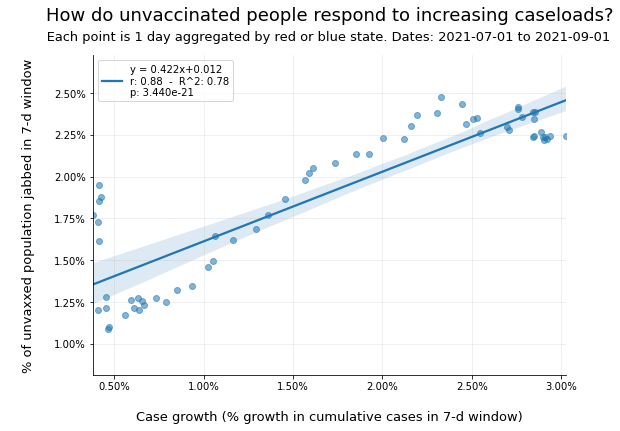

In [10]:
from IPython.display import display


agg_lm(
    data=df_joined_cases,
    groupby=None,
    hue_levels={"Total":"gray"},
    suptitle='Each point is 1 day aggregated by red or blue state',
    start="2021-07-01",
    end="2021-09-01"
    )[0]
